### Vi prøver igen ...

Her er der taget det største datasæt jeg kan finde.

I denne model har jeg strengt opdelt i "train" og "test" data. Den forrige model var forkert på en eller anden måde. Alt ser rigtigt ud, men den nåede 100% korrektned straks. Det er meget mistænkeligt, men jeg slet ikke se fejlen. Derfor laver jeg modellen igen med en stræng opdeling. 

Her viser det sig, at modellen er ret ringe til at forudsige antal stragegilinjer ud fra den skrevne tekst. Men det er også en svær disciplin. Det handler om at finde de 2% af linjerne, hvor der er noget stort. Det er en slags "abnormality detection".

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. OG den timsvarende omsættelse til rådata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Konklusion
Med nogle flere data, nu træning på ca 72.000 rækker, bliver præcisionen noget bedre, men langt fra i mål. Lige nu opnår jeg en fin forskel på rigtig og forkert, men ikke i nærheden af 0/1:
- 0.22  gennemsnit værdi for "rigtig"
- 0.03  gennemsnit værdi for "forkert"

Modellen er ikke rigtig stærk til at spotte rigtig. 
Jeg må dog også konstatere, at dette hele tiden har været et forsæg, hvor jeg godt vidste at der ikke var en stærk sammenhæng, men jeg jeg præver alliegel at få mest muligt ud af systemet. Jeg har lagt mærke til, at "snad" og falsk dog falder i adskilte grupper. Der ser ud til at være en skillelinje omkring 0.1. Hvis det bruges som trigger, så har modellen dog en præcision på 62%, og der er måske ikke så skidt alligevel? :-)

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')
os.listdir()

['.ipynb_checkpoints',
 'FEDAlt_All_texts.xlsx',
 'FEDAlt_test.xlsx',
 'FEDAlt_train.xlsx',
 'FEDData.xlsx',
 'FEDData_All_texts.xlsx',
 'FEDData_test.xlsx',
 'FEDData_train.xlsx',
 'FEDentry.GIF',
 'FEDentry2.GIF',
 'FED_01_FirstModel.ipynb',
 'FED_02_SplitTrainOgTest.ipynb',
 'FED_03_SplitTrainOgTest_AllData.ipynb']

Først laver vi en "dictionary", som omsætter ord til tal. Den bruges efterfølgende til at omsætte train data og test data.

In [2]:
# filen med tekster åbnes og indlæses
file = 'FEDAlt_All_texts.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('FEDlinjer')

# strenge læses over i en tabel
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# henter text processing modul
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som igen kan laves til en "one-hot)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# en funktion som lave en one-hot vektorer
def vectorize_sequences(sequences, dimension=10000):
    # lave en all-zero matrix af formen (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [4]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDAlt_train.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('FEDlinjer')
texts  = df.loc[:,'FEDtext']
labels = df.loc[:,'FEDsize']
FEDid  = df.loc[:,'FEDid']
texts  = texts.values
labels = labels.values

# ord laves til og der "paddes"
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

# One-hot training data
data = vectorize_sequences(data, dimension=max_words)

# labels laves til vektor
labels = np.asarray(labels).astype('float32')

In [5]:
print(data.shape)
print(labels.shape)

(89998, 10000)
(89998,)


In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(data, labels,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2)

Train on 71998 samples, validate on 18000 samples
Epoch 1/20
71998/71998 [==============================] - 17s 229us/step - loss: 0.2977 - acc: 0.9573 - val_loss: 0.1545 - val_acc: 0.9640
Epoch 2/20
71998/71998 [==============================] - 15s 203us/step - loss: 0.1642 - acc: 0.9622 - val_loss: 0.1306 - val_acc: 0.9640
Epoch 3/20
71998/71998 [==============================] - 14s 200us/step - loss: 0.1452 - acc: 0.9628 - val_loss: 0.1306 - val_acc: 0.9641
Epoch 4/20
71998/71998 [==============================] - 15s 213us/step - loss: 0.1395 - acc: 0.9627 - val_loss: 0.1320 - val_acc: 0.9645
Epoch 5/20
71998/71998 [==============================] - 15s 213us/step - loss: 0.1343 - acc: 0.9636 - val_loss: 0.1342 - val_acc: 0.9651
Epoch 6/20
71998/71998 [==============================] - 16s 218us/step - loss: 0.1304 - acc: 0.9641 - val_loss: 0.1344 - val_acc: 0.9657
Epoch 7/20
71998/71998 [==============================] - 16s 222us/step - loss: 0.1281 - acc: 0.9645 - val_loss: 0.

In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

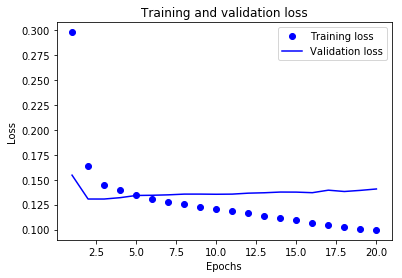

In [16]:
import matplotlib.pyplot as plt

accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs = range(1, len(history_dict['binary_accuracy']) + 1)
epochs = range(1, 21)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

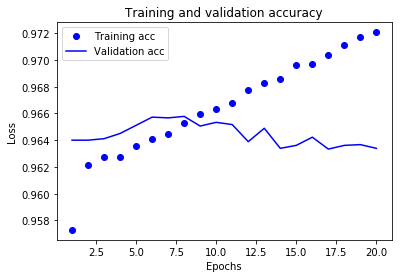

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDAlt_test.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('FEDlinjer')
texts_test  = df.loc[:,'FEDtext']
labels_test = df.loc[:,'FEDsize']
FEDid_test  = df.loc[:,'FEDid']
texts_test  = texts_test.values
labels_test = labels_test.values
FEDid_test  = FEDid_test.values

# ord laves til og der "paddes"
sequences_test = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test)

# One-hot training data
data_test = vectorize_sequences(data_test, dimension=max_words)

# labels laves til vektor
labels_test = np.asarray(labels_test).astype('float32')

In [12]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

# vi printer min, max og nogle eksempler
print(min(predictions), max(predictions))
SplitVal = (min(predictions) + max(predictions))/2

# print(predictions[1:20])

for i in range(1,20):
    print(('%1.4f' % predictions[i]))

[8.8230595e-10] [0.99987054]
0.0005
0.0006
0.0004
0.0089
0.2589
0.0027
0.0090
0.1302
0.0006
0.0225
0.0019
0.0240
0.0052
0.0241
0.0182
0.0274
0.0088
0.0181
0.0145


In [17]:
print('Antal store i datasættet:    ', sum(labels_test))

NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.1 and FEDid_test[i]<=3793:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     420.0
antal estimeret af modellen:  105
Modellens præcision:          25.0 %


In [14]:
# C-style måde at finde gennemsnittet for dem som er rigtige
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels_test)):
    if labels_test[i]:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f  gennemsnit værdi for "rigtig"' % AvgPositive)

# C-style måde at finde gennemsnittet for dem som er FORKERTE
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels_test)):
    if labels_test[i] == 0:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f  gennemsnit værdi for "forkert"' % AvgPositive)

0.22  gennemsnit værdi for "rigtig"
0.03  gennemsnit værdi for "forkert"


In [15]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

for i in range(1,6000):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   5  0.2589  K -12 u Mst.. Signalfejl Trg..
  90  0.8788  1408 har påkørt en person mellem HUM og NI.
 103  0.1948  Har påkørt en bil i OVK 115 mellem RØB og EST.       U- Vagt  Pt bliver de 8 passager i toge
 107  0.0825  Holder i Kd nedbrudt
 138  0.4997  Signalfejl : Svendborgbanen - pronose er, at der resten af dagen skal vendes i Stenstrup. Der fortsæ
 141  0.0219  Lkf til 8302 i Ar., har sygemeldt sig. Og nat-Rdg kan ikke køre ME+DD.. Derfor:
 173  0.0010  Hgl. kan levere nogle sæt til 9338 (3 sæt). Det giver materiel udfordringer i KAC
 192  0.3485  Bdk har mistet kontrollen over et sporskifte i Re.
 210  0.0082  Fokustog for Fredag d. 9. september 2011.
 216  0.0662  F -?? u Kk... Dørfejl.. Lkf er ved at aflåse flere yderdøre..
 241  0.0549  Korrigering. Manglende korrigering af sporarbejde Htå-Hif til aften. Ikke lavet af formiddagsholdet,
 289  0.9479  Mulig ild i en køreledning på Lillebæltsbroen. L 40 er først tog, og efterseer.
 299  0.0350  Kørt fra Ar mod Vy, vi kører t

### Modellen er ikke specielt præcis. jeg checker lige efter på træninsdata, dem kan man håbe den har lært bedre at kende???

In [18]:
# vi prøver modellen på test-data
predictions = model.predict(data)

# vi printer min, max og nogle eksempler
print(min(predictions), max(predictions))
SplitVal = (min(predictions) + max(predictions))/2

# print de første predictions
for i in range(1,20):
    print(('%1.4f' % predictions[i]))

[2.4520379e-11] [1.]
0.0043
0.0211
0.0014
0.0428
0.0401
0.1547
0.0004
0.0035
0.0260
0.0145
0.0210
0.0096
0.0000
0.0016
0.0743
0.0186
0.0207
0.0231
0.0089


In [19]:
print('Antal store i datasættet:    ', sum(labels))

NumEstimated = 0
for i in range(1,len(labels)):
    if predictions[i]>0.1 and labels[i]==1:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(labels)*100), '%')

Antal store i datasættet:     3373.0
antal estimeret af modellen:  2076
Modellens præcision:          62.0 %


In [21]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er rigtige (store)

for i in range(1,len(labels)):
    if labels[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   6  0.1547  Nedformeringer fra Sverige.
  16  0.0186  Pga de tre groundede MF-sæt i Fa., kniber det lidt med materiellet.. Derfor:
  44  0.6979  00:34 Nedbrudt i Svv. Kan kun køre mod Svg, dette gøres. 3 pass i toget taxabefordres. Taxa bestilt 
  89  0.9861  Tif og Epi  Vi er ikke blevet helt færdigt med weekendens sporarbejde mellem Københavns Lufthavn
  99  0.7580  Der mangler 1 ME til morgentrafikken følgende tiltag iværksættes
 166  0.9788  Manglende Lkf Kh, udeblivelse og efterveer efter mandagen samt generelle mangler plus sygemeldinger
 178  0.0633  Grundet mgl på køreklart materiel (vogne og ER4) laves følgede
 206  0.7659  Signalfejl: Alle blok afsnit mellem Lk og Es er gået ned og der bliver kørt på sigt.
 228  0.2882  Holder med brandalarm på vej ud af Vo.
 232  0.1547  Nedformeringer fra Sverige
 314  0.0280  Må ikke køre længere end Kh og til rep
 338  0.4943  Der mangler 1 BR mandag
 352  0.0575  Materiel   holder i RE med fejl på en fjederbremse.
 362  0.0666  signalf

26488  0.5424  Banedanmark       Falskbesættelse i indkørsel spor 1 - 2
26489  0.7241  Der mangler to BR-sæt til den planlagte produktion...
26514  0.6149  Blokfejl, afsnit 2504... Tidstab 4-5 min..
26529  0.9995  PCCAll: Strømmen er gået i Holbæk. Det er derfor ikke muligt at løse billetter eller bruge rejsekort
26555  0.6689  Skinnebrud mellem Hl og Hgl
26591  0.0346  Kraftigt forsinket fra Øst. K -47 Kø.
26638  0.1906  Kb.. Kørsel i omstillingsanlæg, uden valg af rute.. U-vagt underrettet.
26653  0.0298  dørproblemer i svg
26686  0.8113  Disponering Fyn/Jylland i forbindelse med spærring.
26695  0.7409  Personpåkørsel i Hs meldes det via FFØ. Endnu ikke bekræftet fra Bdk.
26703  0.0702  Manglende kontrol på spsk i Hif.
26727  0.3369  BDK øvrige
26745  0.0734  K -3 i Svg.. Fejl på ovk 120 (efter ank Svg går bommene ikke op igen, så 4631 skal udrangeres)
26785  0.2322  DB har ringet og fortalt at der ikke sejler nogen færger mellem Pu-Rf idag
26938  0.9315  Personale      Sydom blendt

35364  0.7439  Der har været melding om bump / dårligt stød mellem Glostrup og Hvidovre fjern, så der køres med ned
35441  0.4872  blokken nede mellem sts-svg  Se Drap.1797470
35461  0.8732  har defekte kompressorer hvilket betyder at sættet er et høj potentielt nedbrud. Fødeledningstryk li
35496  0.3000  Banedanmark, signalfejl flere steder Kbh-Østerport-Helgoland
35525  0.0818  06:48: Materielfejl, holder med bremsefejl lige efter Holmstrup
35555  0.8718  Materielfejl, melding om røgudvikling Od  Synlige flammer derer tilkaldt brandvæsen
35571  0.2213  Har for 4 gang på 1 uge fejl på den tyskeradio
35606  0.0553  Hærværk : Fik smadret rude da det passerede G 9234
35630  0.0671  Materiel: mangler 9 MG i Vest til opstart Fredag
35637  0.8482  Der mangler adskillige MF´ere til dagens produktion..
35691  0.7247  Pga væltede træer kan vi her til morgen IKKE køre tog, mellem Hobro og Aalborg.. Derfor:
35706  0.9488  Sporskiftefejl i Malmö der gør at svenskerne vil have aflyst alle 13xx-tog

59531  0.7991  BDK, melder at toget har kørt flere sporskifter op og fortsat med toget efter signalet er sat på sto
59568  0.0119  Sporarbejde Cph-Phm ikke færdigt til tiden. Ventes klar 05.55
59589  0.1537  Materiel.   Der kommer mange tog fra Sverige der er nedformeret, hvilket vi ikke bliver infomeret om
59590  0.0698  Materiel fejl : Triller mod Svg, lki melder motor fejl og nedbrudt ved ank Svg. Der omdisponeres i O
59597  0.5856  Signalfejl ved Årslev på Svendborgbanen
59602  0.1479  Materiel.  Holder med fejl på toget mellem   HO og TS
59668  0.9962  Ingen kørestrøm mellem Hl-OK samt falsk besættelse i Kl (sket ca. kl. 10.50).
59755  0.0276  Materielfejl MG : holder på KK spor 12 med fejl samme fejl som begge MG holdte med i 206 i OD som vi
59759  0.1547  Nedformeringer fra Sverige
59832  0.9620  K -7 u Sts... Der er ikke rigtig nogen god forklaring på tidstab - men det udvikler sig skidt for al
59849  0.3452  Mangel på Lok og vi får ikke flere færdig fra værksted, samt reserve 

75517  0.0056  Personale: Sygdom hos LKF, betyder vi ikke kan kører følgende tog 2 busser pr. afgang -  Egons Bus
75518  0.0594  Materiel   holder i GL med fejl på bremsen.
75522  0.1131  08:00 Banedanmark:  Mistet strømmen på Odderbanen Chefvagten underettet.
75565  0.9988  Laskebrud brud mellem Marslev og Odense.  To timer frem,  fjerner regionaltog.
75581  0.1336  Personale.    Fejl I turen der er inegn sat op til at omrangere fra spor 2 til 20'erne.  Pt kan 
75593  0.8539  Holder ved Ass , der er fejl på spsk, som vi først hører om nu
75624  0.0305  Materielfejl ME : Vekselretter fejl på Kn
75662  0.1736  Grundet glatte skinner på Svendborgbanen, forsøger vi nu at tynde lidt ud. Derfor disse ændringer...
75689  0.0204  F -?? u Th... Sporskifteproblemer. (3430 og 2423 skal bytte mat i Th)
75831  0.0406  sporskifte fejl HZ
75898  0.0067  Pladsmangel Kd
75906  0.0111  Øvrige Bdk. Problemer med sikringsanlægget. Anlægget er ok nu, men de skubbede krydsninger kan give 
75919  0.0514  De

In [22]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er FORKERTE (små)

for i in range(1,200):
    if labels[i]==0:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   1  0.0043  Lkf. mente han havde ramt noget mellem HK-RT. Lkf. kiggede efter men kunne ikke se noget.  1524 ki
   2  0.0211  Umiddelbart efter afg Lih fortæller Lkf at togsættet meldes nedbrudt ved ank Ab.. Fejl på fejl på 
   3  0.0014  Der er ikke nogen virksomme toiletter i toget. Vi tager rørløbet og kører i BLV og tømmer det.
   4  0.0428  Problemer med at skille af i Nf. LKI tager kontakt.
   5  0.0401  Kører fra Kk med dørfejl, som fejlrettes på Kn ! LKI har bedt lkf om at tømme toget på Kn og komme
   7  0.0004  Der ingen lkf til klargøring P-risten kan ikke hjælpe, det ville har været ok bare de kunne ha start
   8  0.0035  Placering af 2 MR til, at dække togsæt mangler i Es.
   9  0.0260  Disponering DSB.
  10  0.0145  Mgl en ER i FA til 953 da den ikke kom med i 51053 Fra KH pga. den var frossen
  11  0.0210  Materiel
  12  0.0096  Nedbrud hjem til rep.
  13  0.0000  IC4 erstattes med IC3 med vg 91-92.
  14  0.0016  Materielfejl ER : ingen virksomme toiletter
  15  0.0743 

In [28]:
# C-style måde at finde gennemsnittet for dem som er rigtige
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels)):
    if labels[i]:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f gennemsnit værdi for "rigtig" for train data' % AvgPositive)

# C-style måde at finde gennemsnittet for dem som er forkerte
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels)):
    if labels[i] == 0:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f gennemsnit værdi for "forkerte" for train data' % AvgPositive)

# Phytonic måde at gøre det samme på !!!
print(np.average([x for i, x in enumerate(predictions) if labels[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels[i]]))

0.36 gennemsnit værdi for "rigtig" for train data
0.02 gennemsnit værdi for "forkerte" for train data
0.36433163
0.02362803


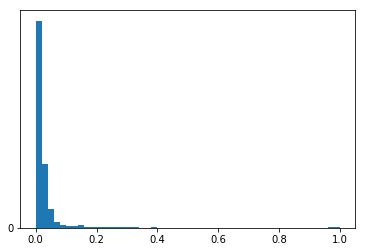

In [34]:
# jeg prøver lige at plotte "predictions i et histogram

plt.clf()   # clear figure

plt.hist(predictions, bins=50)
plt.yticks(range(0, 1))

plt.show()

